# Imports

In [127]:
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from ibm_watson.natural_language_understanding_v1 import Features, SentimentOptions
import json
import pandas as pd
import datetime
import pathlib
import time
import numpy as np
import statistics
import matplotlib.pyplot as plt

# Credentials and Authorization

In [123]:
with open("credentials.json", 'r') as jsonfile:
    credentials = json.load(jsonfile)['ibm-watson']

authenticator = IAMAuthenticator(credentials['api-key'])
natural_language_understanding = NaturalLanguageUnderstandingV1(
    version=credentials['version'],
    authenticator=authenticator
)
natural_language_understanding.set_service_url(credentials['url'])

tweets_df = pd.read_csv(str(pathlib.Path().absolute()) + '\\datasets\\firstRound.csv')
tweets_df.head()

,Username,Created_at,Text
0,DelPatricia19,2020-11-13 20:55:28,hora decisao vamos unir fazer mudanca recife p...
1,DelPatricia19,2020-11-13 20:38:56,agradecemos apoio vamos juntos mudar recife
2,DelPatricia19,2020-11-13 20:37:57,vamos juntos fazer recife melhor
3,DelPatricia19,2020-11-13 20:37:38,vamos juntos
4,DelPatricia19,2020-11-13 20:00:20,mudanca chegou chama delegada patricia domingo...


# Sentiment Analysis

In [124]:
def analyseSentiment(text):
    response = natural_language_understanding.analyze(
    text=text,
    language = 'pt',
    features=Features(sentiment=SentimentOptions(document=True))).get_result()
    return (response['sentiment']['document']['label'],response['sentiment']['document']['score'])


In [125]:
label = []
score = []
for t in tweets_df.Text:
    result = analyse(t)
    label.append(result[0])
    score.append(result[1])
    
tweets_df['Label'] = label
tweets_df['Score'] = score

tweets_df.head()

,Username,Created_at,Text,Label,Score
0,DelPatricia19,2020-11-13 20:55:28,hora decisao vamos unir fazer mudanca recife p...,neutral,0.000000
1,DelPatricia19,2020-11-13 20:38:56,agradecemos apoio vamos juntos mudar recife,positive,0.884153
2,DelPatricia19,2020-11-13 20:37:57,vamos juntos fazer recife melhor,positive,0.927721
3,DelPatricia19,2020-11-13 20:37:38,vamos juntos,positive,0.905184
4,DelPatricia19,2020-11-13 20:00:20,mudanca chegou chama delegada patricia domingo...,neutral,0.000000


# Generate CSV - First Round with Sentiment Analysis

In [130]:
tweets_df['Created_at'] = tweets_df['Created_at'].apply(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S'))
tweets_df.to_csv(str(pathlib.Path().absolute()) + '\\datasets\\firstRoundWithSA.csv', index=False)

# Delegada Patricia tweets

In [190]:
delPatricia_tweets = tweets_df[tweets_df['Username'] == 'DelPatricia19']

# Datetime to Date
delPatricia_tweets['Created_at'] = delPatricia_tweets['Created_at'].apply(lambda d: d.date())

# Filter by Label
delPatricia_tweets = delPatricia_tweets[(delPatricia_tweets.Label == 'positive') | (delPatricia_tweets.Label == 'negative')]

delPatricia_tweets.head()

<ipython-input-190-01980539edaa>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delPatricia_tweets['Created_at'] = delPatricia_tweets['Created_at'].apply(lambda d: d.date())


,Username,Created_at,Text,Label,Score
1,DelPatricia19,2020-11-13,agradecemos apoio vamos juntos mudar recife,positive,0.884153
2,DelPatricia19,2020-11-13,vamos juntos fazer recife melhor,positive,0.927721
3,DelPatricia19,2020-11-13,vamos juntos,positive,0.905184
5,DelPatricia19,2020-11-13,vamos juntas,positive,0.834304
6,DelPatricia19,2020-11-13,vamos juntos construir cidade melhor,positive,0.965889


In [194]:
scorebyDate_dp = delPatricia_tweets.groupby(by=['Created_at'])['Score'].apply(list).to_frame()

scorebyDate_dp['Positive'] = scorebyDate_dp['Score'].apply(lambda s: [score for score in s if score > 0])
scorebyDate_dp['Negative'] = scorebyDate_dp['Score'].apply(lambda s: [score for score in s if score < 0])

scorebyDate_dp['Positive quantity'] = scorebyDate_dp['Positive'].apply(lambda s: len(s))
scorebyDate_dp['Negative quantity'] = scorebyDate_dp['Negative'].apply(lambda s: len(s) * -1)

scorebyDate_dp['Positive mean'] = scorebyDate_dp['Positive'].apply(lambda s: 0 if s == [] else statistics.mean(s))
scorebyDate_dp['Negative mean'] = scorebyDate_dp['Negative'].apply(lambda s: 0 if s == [] else statistics.mean(s))

scorebyDate_dp.head()

,Score,Positive,Negative,Positive quantity,Negative quantity,Positive mean,Negative mean
Created_at,,,,,,,
2020-09-27,"[0.709068, 0.923776, -0.857582, 0.954598, 0.78...","[0.709068, 0.923776, 0.954598, 0.78955, 0.8746...","[-0.857582, -0.472787]",10,-2,0.833942,-0.665184
2020-09-28,"[0.598922, 0.89928, -0.400352]","[0.598922, 0.89928]",[-0.400352],2,-1,0.749101,-0.400352
2020-09-29,"[0.866092, 0.978175, 0.935493, 0.95688, 0.9496...","[0.866092, 0.978175, 0.935493, 0.95688, 0.9496...","[-0.375769, -0.669125, -0.891273, -0.980142, -...",9,-5,0.893963,-0.743082
2020-09-30,"[-0.559151, 0.905184, 0.93734, -0.867293, 0.86...","[0.905184, 0.93734, 0.868747, 0.913933, 0.6478...","[-0.559151, -0.867293, -0.906181]",9,-3,0.872786,-0.777542
2020-10-01,"[0.772802, 0.34535, 0.778421, -0.529352]","[0.772802, 0.34535, 0.778421]",[-0.529352],3,-1,0.632191,-0.529352


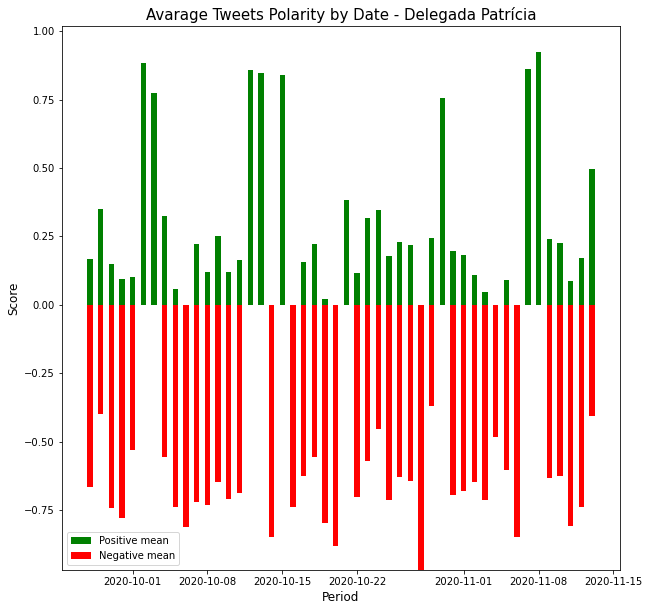

In [195]:
fig, ax = plt.subplots(figsize=(10,10))
width = 0.50 

p1 = plt.bar(scorebyDate_dp.index,scorebyDate_dp['Positive mean'], width, bottom=scorebyDate_dp['Negative mean'], color='g')
p2 = plt.bar(scorebyDate_dp.index,scorebyDate_dp['Negative mean'], width, color='r')

plt.title('Avarage Tweets Polarity by Date - Delegada Patrícia',fontsize=15)
plt.xlabel('Period',fontsize=12)
plt.ylabel('Score',fontsize=12)
plt.legend((p1[0], p2[0]), ('Positive mean', 'Negative mean'),fontsize=10)

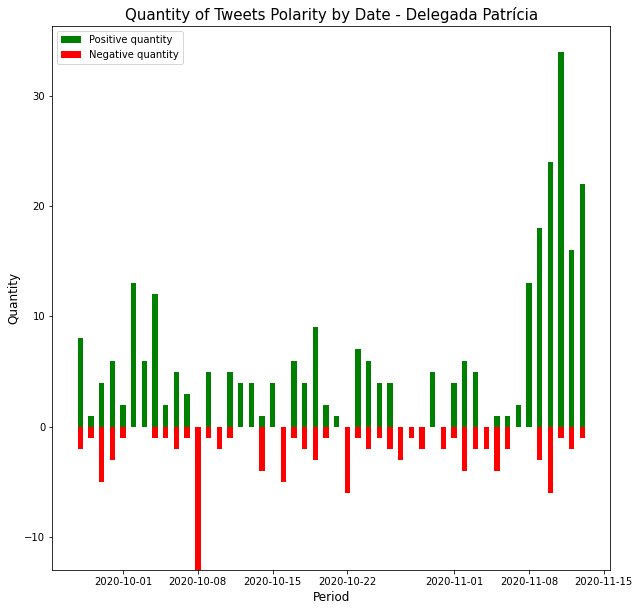

In [199]:
fig, ax = plt.subplots(figsize=(10,10))
width = 0.50 

p1 = plt.bar(scorebyDate_dp.index,scorebyDate_dp['Positive quantity'], width, bottom=scorebyDate_dp['Negative quantity'], color='g')
p2 = plt.bar(scorebyDate_dp.index,scorebyDate_dp['Negative quantity'], width, color='r')

plt.title('Quantity of Tweets Polarity by Date - Delegada Patrícia',fontsize=15)
plt.xlabel('Period',fontsize=12)
plt.ylabel('Quantity',fontsize=12)
plt.legend((p1[0], p2[0]), ('Positive quantity', 'Negative quantity'),fontsize=10)

# João Campos tweets

In [176]:
joaoCampos_tweets = tweets_df[tweets_df['Username'] == 'JoaoCampos']

# Datetime to Date
joaoCampos_tweets['Created_at'] = joaoCampos_tweets['Created_at'].apply(lambda d: d.date())

# Filter by Label
joaoCampos_tweets = joaoCampos_tweets[(joaoCampos_tweets.Label == 'positive') | (joaoCampos_tweets.Label == 'negative')]

joaoCampos_tweets.head()

<ipython-input-176-c17fccfeaf4c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joaoCampos_tweets['Created_at'] = joaoCampos_tweets['Created_at'].apply(lambda d: d.date())


,Username,Created_at,Text,Label,Score
624,JoaoCampos,2020-11-13,jingle tomou conta recife voce ja sabe agora v...,positive,0.761809
626,JoaoCampos,2020-11-10,capacidade ousar gestao somada poder juventude...,negative,-0.679297
628,JoaoCampos,2020-11-10,quero agradecer cada acolhida longo dessa cami...,positive,0.914205
629,JoaoCampos,2020-11-10,proposta isentar tarifa esgoto familias baixa ...,negative,-0.685364
632,JoaoCampos,2020-11-10,capacidade ousar gestao somada poder juventude...,negative,-0.520782


In [197]:
scorebyDate_jc = joaoCampos_tweets.groupby(by=['Created_at'])['Score'].apply(list).to_frame()

scorebyDate_jc['Positive'] = scorebyDate_jc['Score'].apply(lambda s: [score for score in s if score > 0])
scorebyDate_jc['Negative'] = scorebyDate_jc['Score'].apply(lambda s: [score for score in s if score < 0])

scorebyDate_jc['Positive quantity'] = scorebyDate_jc['Positive'].apply(lambda s: len(s))
scorebyDate_jc['Negative quantity'] = scorebyDate_jc['Negative'].apply(lambda s: len(s) * -1)

scorebyDate_jc['Positive mean'] = scorebyDate_jc['Positive'].apply(lambda s: 0 if s == [] else statistics.mean(s))
scorebyDate_jc['Negative mean'] = scorebyDate_jc['Negative'].apply(lambda s: 0 if s == [] else statistics.mean(s))

scorebyDate_jc.head()

,Score,Positive,Negative,Positive quantity,Negative quantity,Positive mean,Negative mean
Created_at,,,,,,,
2020-09-28,"[0.697361, 0.880535, -0.821735, 0.984147]","[0.697361, 0.880535, 0.984147]",[-0.821735],3,-1,0.854014,-0.821735
2020-09-29,"[-0.888963, 0.350822, -0.684382]",[0.350822],"[-0.888963, -0.684382]",1,-2,0.350822,-0.786672
2020-09-30,"[0.913862, 0.783965, 0.970137, 0.783965, 0.754...","[0.913862, 0.783965, 0.970137, 0.783965, 0.754...",[-0.281047],6,-1,0.862292,-0.281047
2020-10-01,"[0.816886, 0.607325, -0.847931, 0.573068, -0.9...","[0.816886, 0.607325, 0.573068, 0.85013]","[-0.847931, -0.987341]",4,-2,0.711852,-0.917636
2020-10-02,[0.861903],[0.861903],[],1,0,0.861903,0.000000


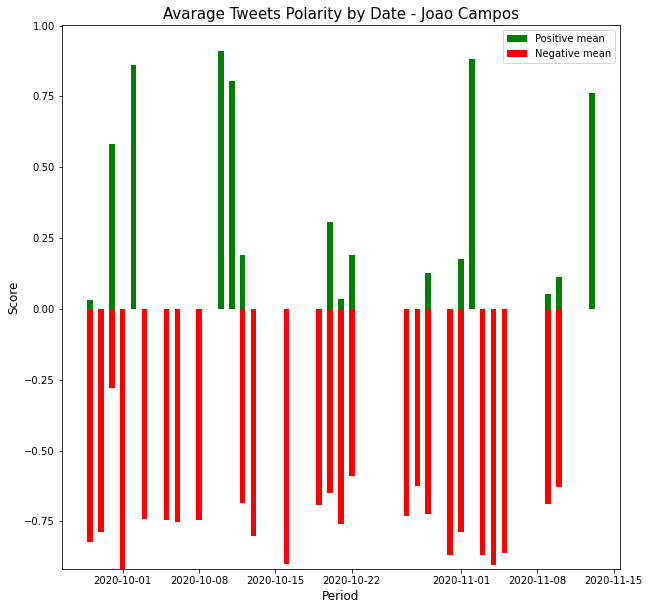

In [198]:
fig, ax = plt.subplots(figsize=(10,10))
width = 0.50 

p1 = plt.bar(scorebyDate_jc.index,scorebyDate_jc['Positive mean'], width, bottom=scorebyDate_jc['Negative mean'], color='g')
p2 = plt.bar(scorebyDate_jc.index,scorebyDate_jc['Negative mean'], width, color='r')

plt.title('Avarage Tweets Polarity by Date - Joao Campos',fontsize=15)
plt.xlabel('Period',fontsize=12)
plt.ylabel('Score',fontsize=12)
plt.legend((p1[0], p2[0]), ('Positive mean', 'Negative mean'),fontsize=10)

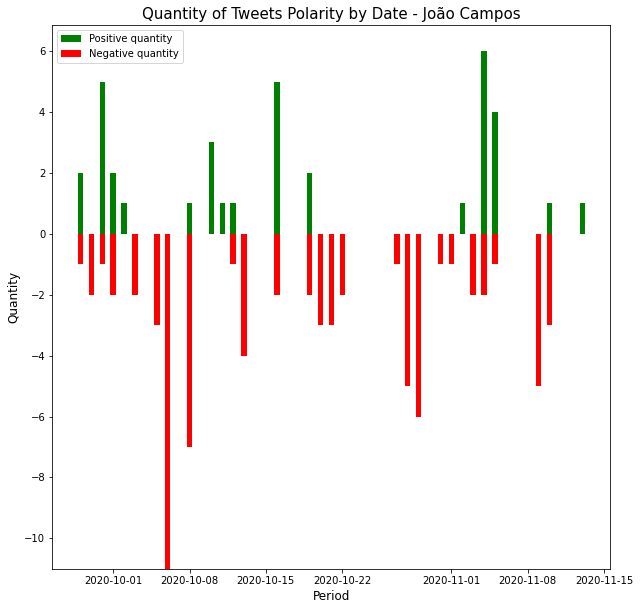

In [200]:
fig, ax = plt.subplots(figsize=(10,10))
width = 0.50 

p1 = plt.bar(scorebyDate_jc.index,scorebyDate_jc['Positive quantity'], width, bottom=scorebyDate_jc['Negative quantity'], color='g')
p2 = plt.bar(scorebyDate_jc.index,scorebyDate_jc['Negative quantity'], width, color='r')

plt.title('Quantity of Tweets Polarity by Date - João Campos',fontsize=15)
plt.xlabel('Period',fontsize=12)
plt.ylabel('Quantity',fontsize=12)
plt.legend((p1[0], p2[0]), ('Positive quantity', 'Negative quantity'),fontsize=10)

# Marília Arraes tweets

In [184]:
mariliaArraes_tweets = tweets_df[tweets_df['Username'] == 'MariliaArraes']

# Datetime to Date
mariliaArraes_tweets['Created_at'] = mariliaArraes_tweets['Created_at'].apply(lambda d: d.date())

# Filter by Label
mariliaArraes_tweets = mariliaArraes_tweets[(mariliaArraes_tweets.Label == 'positive') | (mariliaArraes_tweets.Label == 'negative')]

mariliaArraes_tweets.head()

<ipython-input-184-9474c8b21488>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mariliaArraes_tweets['Created_at'] = mariliaArraes_tweets['Created_at'].apply(lambda d: d.date())


,Username,Created_at,Text,Label,Score
942,MariliaArraes,2020-11-13,troinhaaaa,positive,0.386655
943,MariliaArraes,2020-11-13,noite acabei conversar participacao especial f...,positive,0.700538
944,MariliaArraes,2020-11-13,rt quero fazer promessa aqui ganhar quero ir p...,positive,0.437789
945,MariliaArraes,2020-11-13,daqui recife vai sair primavera pra libertar b...,negative,-0.749992
946,MariliaArraes,2020-11-13,promessas dessas gente perto nunca virar pagin...,negative,-0.933886


In [201]:
scorebyDate_ma = mariliaArraes_tweets.groupby(by=['Created_at'])['Score'].apply(list).to_frame()

scorebyDate_ma['Positive'] = scorebyDate_ma['Score'].apply(lambda s: [score for score in s if score > 0])
scorebyDate_ma['Negative'] = scorebyDate_ma['Score'].apply(lambda s: [score for score in s if score < 0])

scorebyDate_ma['Positive quantity'] = scorebyDate_ma['Positive'].apply(lambda s: len(s))
scorebyDate_ma['Negative quantity'] = scorebyDate_ma['Negative'].apply(lambda s: len(s) * -1)

scorebyDate_ma['Positive mean'] = scorebyDate_ma['Positive'].apply(lambda s: 0 if s == [] else statistics.mean(s))
scorebyDate_ma['Negative mean'] = scorebyDate_ma['Negative'].apply(lambda s: 0 if s == [] else statistics.mean(s))

scorebyDate_ma.head()

,Score,Positive,Negative,Positive quantity,Negative quantity,Positive mean,Negative mean
Created_at,,,,,,,
2020-09-27,"[0.629973, 0.991467, 0.970158, -0.500153, 0.89...","[0.629973, 0.991467, 0.970158, 0.896278, 0.846...","[-0.500153, -0.351499]",5,-2,0.866824,-0.425826
2020-09-28,"[0.775266, 0.65094, -0.481323]","[0.775266, 0.65094]",[-0.481323],2,-1,0.713103,-0.481323
2020-09-29,"[0.991829, 0.792042, 0.842602, 0.584652, -0.71...","[0.991829, 0.792042, 0.842602, 0.584652]","[-0.713906, -0.868346]",4,-2,0.802781,-0.791126
2020-09-30,"[0.742008, -0.765428]",[0.742008],[-0.765428],1,-1,0.742008,-0.765428
2020-10-01,"[-0.740885, -0.221436, -0.834516, -0.837807, -...","[0.572462, 0.39843, 0.605648]","[-0.740885, -0.221436, -0.834516, -0.837807, -...",3,-11,0.525513,-0.697652


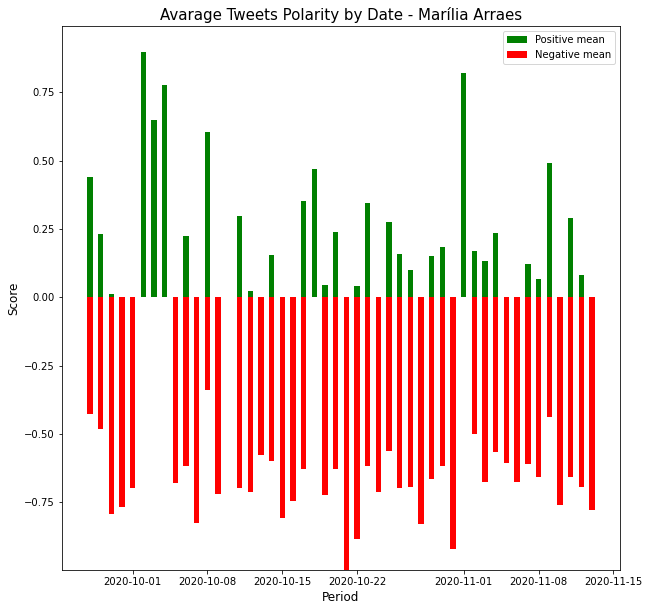

In [202]:
fig, ax = plt.subplots(figsize=(10,10))
width = 0.50 

p1 = plt.bar(scorebyDate_ma.index,scorebyDate_ma['Positive mean'], width, bottom=scorebyDate_ma['Negative mean'], color='g')
p2 = plt.bar(scorebyDate_ma.index,scorebyDate_ma['Negative mean'], width, color='r')

plt.title('Avarage Tweets Polarity by Date - Marília Arraes',fontsize=15)
plt.xlabel('Period',fontsize=12)
plt.ylabel('Score',fontsize=12)
plt.legend((p1[0], p2[0]), ('Positive mean', 'Negative mean'),fontsize=10)

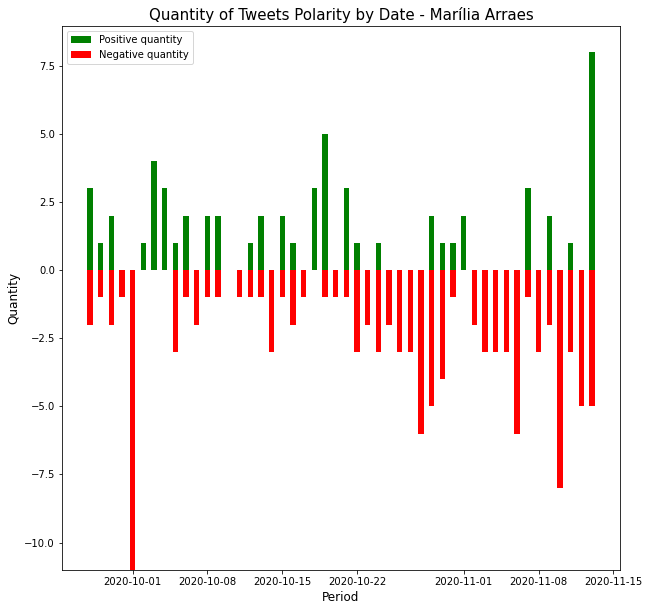

In [203]:
fig, ax = plt.subplots(figsize=(10,10))
width = 0.50 

p1 = plt.bar(scorebyDate_ma.index,scorebyDate_ma['Positive quantity'], width, bottom=scorebyDate_ma['Negative quantity'], color='g')
p2 = plt.bar(scorebyDate_ma.index,scorebyDate_ma['Negative quantity'], width, color='r')

plt.title('Quantity of Tweets Polarity by Date - Marília Arraes',fontsize=15)
plt.xlabel('Period',fontsize=12)
plt.ylabel('Quantity',fontsize=12)
plt.legend((p1[0], p2[0]), ('Positive quantity', 'Negative quantity'),fontsize=10)

# Mendonça Filho tweets

In [187]:
mendoncaFilho_tweets = tweets_df[tweets_df['Username'] == 'mendoncafilho']

# Datetime to Date
mendoncaFilho_tweets['Created_at'] = mendoncaFilho_tweets['Created_at'].apply(lambda d: d.date())

# Filter by Label
mendoncaFilho_tweets = mendoncaFilho_tweets[(mendoncaFilho_tweets.Label == 'positive') | (mendoncaFilho_tweets.Label == 'negative')]

mendoncaFilho_tweets.head()

<ipython-input-187-e82129cb76ee>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mendoncaFilho_tweets['Created_at'] = mendoncaFilho_tweets['Created_at'].apply(lambda d: d.date())


,Username,Created_at,Text,Label,Score
1337,mendoncafilho,2020-11-13,recife sao milhares familias pisam diariamente...,negative,-0.821362
1339,mendoncafilho,2020-11-13,vamos segundo turno vamos ganhar eleicoes vamo...,negative,-0.546412
1344,mendoncafilho,2020-11-12,alem congelar impedir reajustes vamos revisar ...,negative,-0.544704
1347,mendoncafilho,2020-11-12,estado maior concentracao renda brasil extrema...,negative,-0.920932
1348,mendoncafilho,2020-11-12,deprimente anos gestao pt psb deixem cidade le...,negative,-0.937280


In [204]:
scorebyDate_mf = mendoncaFilho_tweets.groupby(by=['Created_at'])['Score'].apply(list).to_frame()

scorebyDate_mf['Positive'] = scorebyDate_mf['Score'].apply(lambda s: [score for score in s if score > 0])
scorebyDate_mf['Negative'] = scorebyDate_mf['Score'].apply(lambda s: [score for score in s if score < 0])

scorebyDate_mf['Positive quantity'] = scorebyDate_mf['Positive'].apply(lambda s: len(s))
scorebyDate_mf['Negative quantity'] = scorebyDate_mf['Negative'].apply(lambda s: len(s) * -1)

scorebyDate_mf['Positive mean'] = scorebyDate_mf['Positive'].apply(lambda s: 0 if s == [] else statistics.mean(s))
scorebyDate_mf['Negative mean'] = scorebyDate_mf['Negative'].apply(lambda s: 0 if s == [] else statistics.mean(s))

scorebyDate_mf.head()

,Score,Positive,Negative,Positive quantity,Negative quantity,Positive mean,Negative mean
Created_at,,,,,,,
2020-09-27,"[-0.837548, -0.902412]",[],"[-0.837548, -0.902412]",0,-2,0.000000,-0.869980
2020-09-29,"[-0.598734, -0.69844]",[],"[-0.598734, -0.69844]",0,-2,0.000000,-0.648587
2020-09-30,"[-0.891428, -0.984585, 0.854082, -0.522783]",[0.854082],"[-0.891428, -0.984585, -0.522783]",1,-3,0.854082,-0.799599
2020-10-01,"[-0.830606, 0.784298, 0.905184, -0.795009, 0.4...","[0.784298, 0.905184, 0.413689, 0.940799, 0.687...","[-0.830606, -0.795009]",9,-2,0.783558,-0.812807
2020-10-02,"[0.922626, 0.652774, 0.416948, -0.990732]","[0.922626, 0.652774, 0.416948]",[-0.990732],3,-1,0.664116,-0.990732


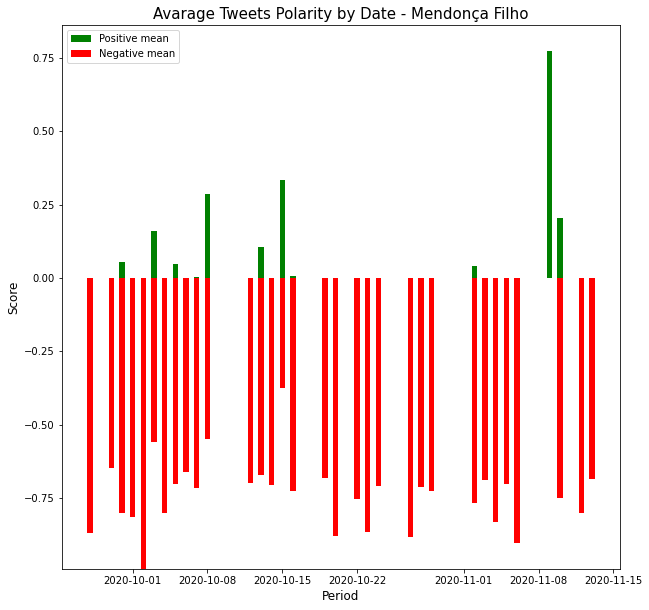

In [205]:
fig, ax = plt.subplots(figsize=(10,10))
width = 0.50 

p1 = plt.bar(scorebyDate_mf.index,scorebyDate_mf['Positive mean'], width, bottom=scorebyDate_mf['Negative mean'], color='g')
p2 = plt.bar(scorebyDate_mf.index,scorebyDate_mf['Negative mean'], width, color='r')

plt.title('Avarage Tweets Polarity by Date - Mendonça Filho',fontsize=15)
plt.xlabel('Period',fontsize=12)
plt.ylabel('Score',fontsize=12)
plt.legend((p1[0], p2[0]), ('Positive mean', 'Negative mean'),fontsize=10)

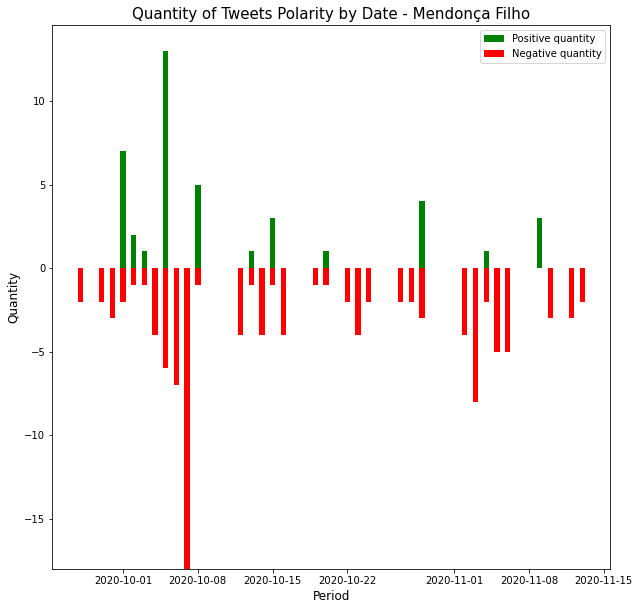

In [206]:
fig, ax = plt.subplots(figsize=(10,10))
width = 0.50 

p1 = plt.bar(scorebyDate_mf.index,scorebyDate_mf['Positive quantity'], width, bottom=scorebyDate_mf['Negative quantity'], color='g')
p2 = plt.bar(scorebyDate_mf.index,scorebyDate_mf['Negative quantity'], width, color='r')

plt.title('Quantity of Tweets Polarity by Date - Mendonça Filho',fontsize=15)
plt.xlabel('Period',fontsize=12)
plt.ylabel('Quantity',fontsize=12)
plt.legend((p1[0], p2[0]), ('Positive quantity', 'Negative quantity'),fontsize=10)